In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from scipy import interpolate

#Assume installed from github using "git clone --recursive https://github.com/cmbant/CAMB.git"
#This file is then in the docs folders
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.1.0 installed at /home/liang/anaconda3/lib/python3.8/site-packages/camb


In [3]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0);

In [4]:
#calculate results for these parameters
results = camb.get_results(pars)

In [5]:
#get dictionary of CAMB power spectra
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')
for name in powers: print(name)

total
unlensed_scalar
unlensed_total
lensed_scalar
tensor
lens_potential


(2551, 4)


Text(0.5, 1.0, 'TT')

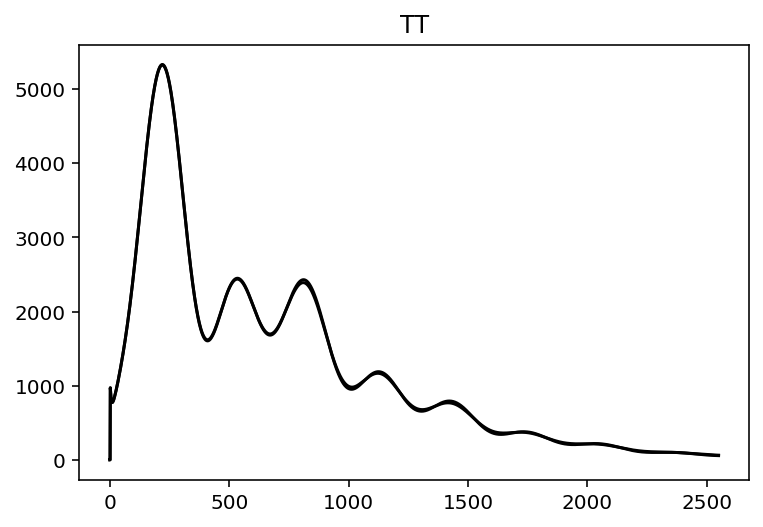

In [6]:
#plot the total lensed CMB power spectra versus unlensed, and fractional difference
totCL=powers['total']
unlensedCL=powers['unlensed_scalar']
print(totCL.shape)
#Python CL arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
#The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).
ls = np.arange(totCL.shape[0])
plt.plot(ls,totCL[:,0], color='k')
plt.plot(ls,unlensedCL[:,0], color='k')
plt.title('TT')

In [7]:
totCL[:,0]

array([  0.        ,   0.        , 971.24650246, ...,  63.02370181,
        62.90733531,  62.79243936])

In [10]:
##-------parameter setting-----------##

#number of pixel
n_sides = 512
#field degree (have to be a squared field)
field_deg = 3.41
#comoving distance
chi = 14000.0 #in the unit of [Mpc]

TT_unlensed = unlensedCL[:,0]
ell = ls
np.savetxt('try1.dat', np.c_[ell,TT_unlensed], fmt='%1.4e')

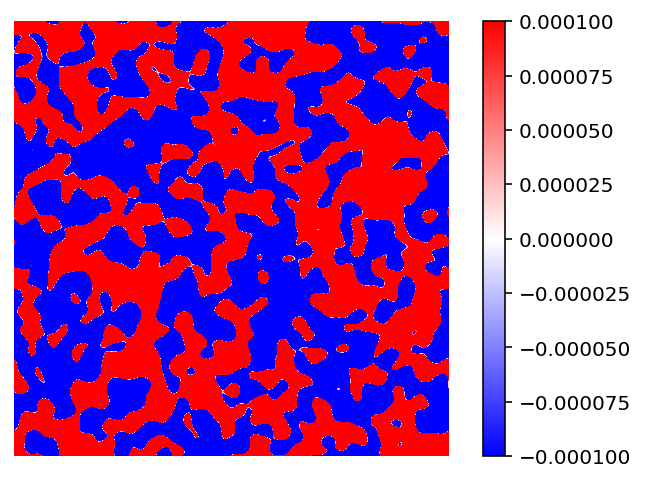

In [11]:


#pixelization setup

l_min = 360.0/field_deg #ell minimum ell=2pi/theta
l_max = n_sides * l_min
#sample y-axis n_sides frequencies in the range of (-l_amx/2, l_max/2)
ly = np.fft.fftfreq(n_sides)*l_max #* l_max
#sample x-axis only need half of the frequency domain (due to numpy.fft convention)
#the input of real ifft, is a (N,N/2+1) with N=n_sides, complex matrix
#since it is the real discrete fourier transform, we only need to sample the zero- and positive- frequencies by rfftfreq. Hence, actually, we only sample (0,l_max/2)
lx = np.fft.rfftfreq(n_sides)*l_max

#print(lx.shape)
#print(ly.shape)

#Compute the multipole moment of each FFT pixel
#l is N*(N/2+1) complex matrix, with N=n_sides
#each component in the l matrix is the module of wave vectors
l = np.sqrt(lx[np.newaxis,:]**2 + ly[:,np.newaxis]**2)
#print(l.shape)

#Perform the interpolation, the interpolation range may outof bound of sampling points
power_interp = interpolate.interp1d(ell,TT_unlensed,bounds_error=False,kind='linear',fill_value=0.0)
Pl = power_interp(l)

#test suite: generate the same random variable set every time
np.random.seed(1)

#Generate real and imaginary parts
#bh: not sure about the scaling factor: l_min/(2.0*np.pi)
real_part = np.sqrt(0.5*Pl) * np.random.normal(loc=0.0,scale=1.0,size=l.shape)
imaginary_part = np.sqrt(0.5*Pl) * np.random.normal(loc=0.0,scale=1.0,size=l.shape)
#print(real_part.shape)

#Get map in real space and return
#bh: not sure about the scaling factor: l.shape[0]**2
ft_map = (real_part + imaginary_part*1.0j)
#print(ft_map.shape)

#ft_map is a (N,N/2+1) complex matrix, noise_map is a (N,N) matrix
noise_map = np.fft.irfft2(ft_map)

np.savetxt('map_data.dat', noise_map)

'''
#testing visualization
map_data_path = './map_data.dat'
map_data = np.loadtxt(map_data_path)
plt.imshow(map_data)
'''

plt.imshow(noise_map,cmap='bwr',vmin=-1e-4,vmax=1e-4)
#plt.imshow(noise_map)
#plt.show()

plt.axis('off')
plt.colorbar()
plt.savefig('map.png')

exit()